In [ ]:
!pip install numpy

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification, AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm

In [ ]:
   from google.colab import drive

   drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np

def decode_one_hot(dataframe, filename, labels, col_name):
  one_hot_labels = np.genfromtxt(dataset_path+filename, delimiter=',')
  index_labels = np.argmax(one_hot_labels, axis=1)
  labels_train = list(map(lambda x: labels[x], index_labels))

  dataframe.insert(dataframe.shape[1], col_name, labels_train, True)
  return dataframe


In [ ]:
dataset_path = "/content/drive/MyDrive/PLN/data/split_data/"

df_train = pd.read_csv(dataset_path+"train_data.csv")
df_val = pd.read_csv(dataset_path+"validation_data.csv")
df_test = pd.read_csv(dataset_path+"test_data.csv")

,IMG,Text,Label_1,Label_2
0,DS_IMG_1075,Cuando te das cuenta que no es mugre @alexesmu,hate_speech,racism
1,DS_IMG_2669,Ya estaríamos en octavos; si alguien no fallab...,none,none
2,DS_IMG_2593,Nadie: Lo de Cinepolis que se quedaron con tod...,none,none
3,DS_IMG_261,Dice que los tragos hicieron estrago en su cab...,hate_speech,sexism
4,DS_IMG_1037,Cuando te salen tus 3 novias al mismo tiempo O...,none,none
...,...,...,...,...
2258,DS_IMG_456,Elhomofóbico promedio,inappropiate_content,inappropiate_content
2259,DS_IMG_642,Cuando te quieres pajear pero tu perro no se v...,inappropiate_content,inappropiate_content
2260,DS_IMG_2480,CUANDO YA ESTAS LISTO PARA DAR EL GRITO CON TU...,none,none
2261,DS_IMG_327,Cuando Ix acabas de conocer y te dice No soy f...,none,none


In [ ]:
# Longitud de cada texto
df['Text_Length'] = df['Text'].apply(len)

# Media de la longitud de los textos
mean_length = df['Text_Length'].mean()

# Moda de la longitud de los textos
mode_length = df['Text_Length'].mode()[0]  # En caso de que haya múltiples modas, selecciona la primera

# Cuartiles de la longitud de los textos
quartiles = df['Text_Length'].quantile([0.25, 0.5, 0.75])

# Imprimir las métricas
print("Longitud media de los textos:", mean_length)
print("Moda de la longitud de los textos:", mode_length)
print("Cuartiles de la longitud de los textos:")
print(quartiles)

Longitud media de los textos: 78.72646928855501
Moda de la longitud de los textos: 53
Cuartiles de la longitud de los textos:
0.25    48.0
0.50    69.0
0.75    96.0
Name: Text_Length, dtype: float64


In [ ]:
counts_train1 = df_train['Label_1'].value_counts().to_dict()
print("Distribución en training label1: ", counts_train1)
counts_val1 = df_val['Label_1'].value_counts().to_dict()
print("Distribución en validation label1: ", counts_val1)
counts_test1 = df_test['Label_1'].value_counts().to_dict()
print("Distribución en test label1: ", counts_test1)

counts_train2 = df_train['Label_2'].value_counts().to_dict()
print("Distribución en training label2: ", counts_train2)
counts_val2 = df_val['Label_2'].value_counts().to_dict()
print("Distribución en validation label2: ", counts_val2)
counts_test2 = df_test['Label_2'].value_counts().to_dict()
print("Distribución en test label2: ", counts_test2)



Distribución en training label1:  {'none': 991, 'inappropiate_content': 322, 'hate_speech': 271}
Distribución en validation label1:  {'none': 205, 'inappropiate_content': 74, 'hate_speech': 60}
Distribución en test label1:  {'none': 209, 'inappropiate_content': 76, 'hate_speech': 55}
Distribución en training label2:  {'none': 991, 'inappropiate_content': 322, 'sexism': 108, 'racism': 80, 'other': 52, 'classicism': 31}
Distribución en validation label2:  {'none': 205, 'inappropiate_content': 74, 'sexism': 24, 'racism': 18, 'other': 13, 'classicism': 5}
Distribución en test label2:  {'none': 209, 'inappropiate_content': 76, 'sexism': 24, 'racism': 16, 'classicism': 8, 'other': 7}


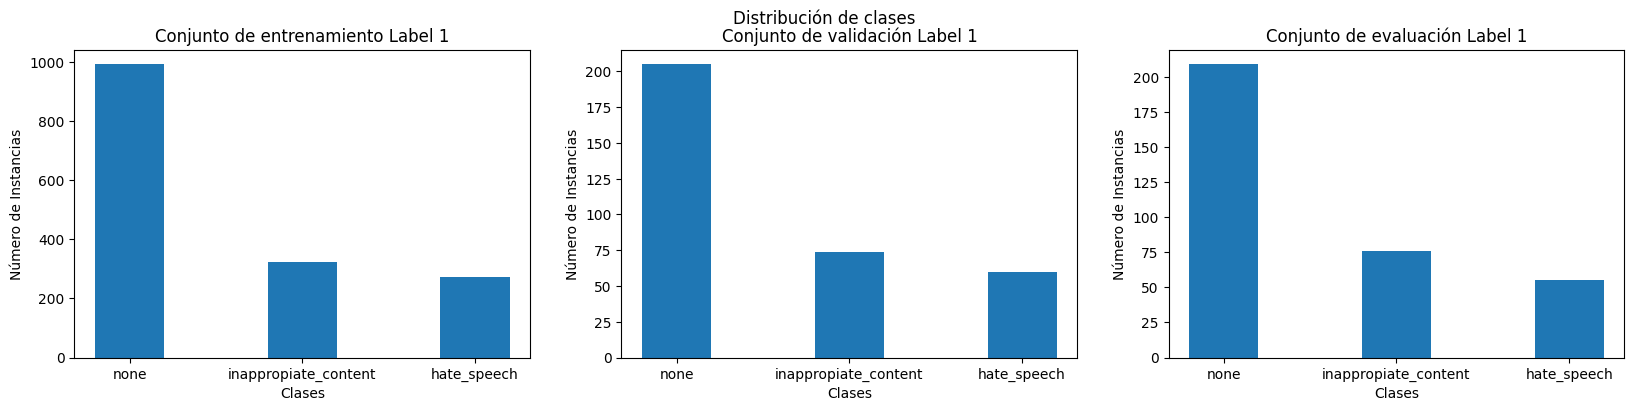

In [ ]:
import matplotlib.pyplot as plt

# Definir etiquetas
LABELS = list(counts_train1.keys())  # Usamos las etiquetas del primer conjunto, podrías usar cualquier otro

fig, (ax_train, ax_val, ax_test) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Distribución de clases')

# Gráfico para conjunto de entrenamiento
ax_train.bar(LABELS, counts_train1.values(), width=0.4)
ax_train.set_title('Conjunto de entrenamiento Label 1')
ax_train.set_xlabel('Clases')
ax_train.set_ylabel('Número de Instancias')

# Gráfico para conjunto de validación
ax_val.bar(LABELS, counts_val1.values(), width=0.4)
ax_val.set_title('Conjunto de validación Label 1')
ax_val.set_xlabel('Clases')
ax_val.set_ylabel('Número de Instancias')

# Gráfico para conjunto de evaluación
ax_test.bar(LABELS, counts_test1.values(), width=0.4)
ax_test.set_title('Conjunto de evaluación Label 1')
ax_test.set_xlabel('Clases')
ax_test.set_ylabel('Número de Instancias')

plt.show()


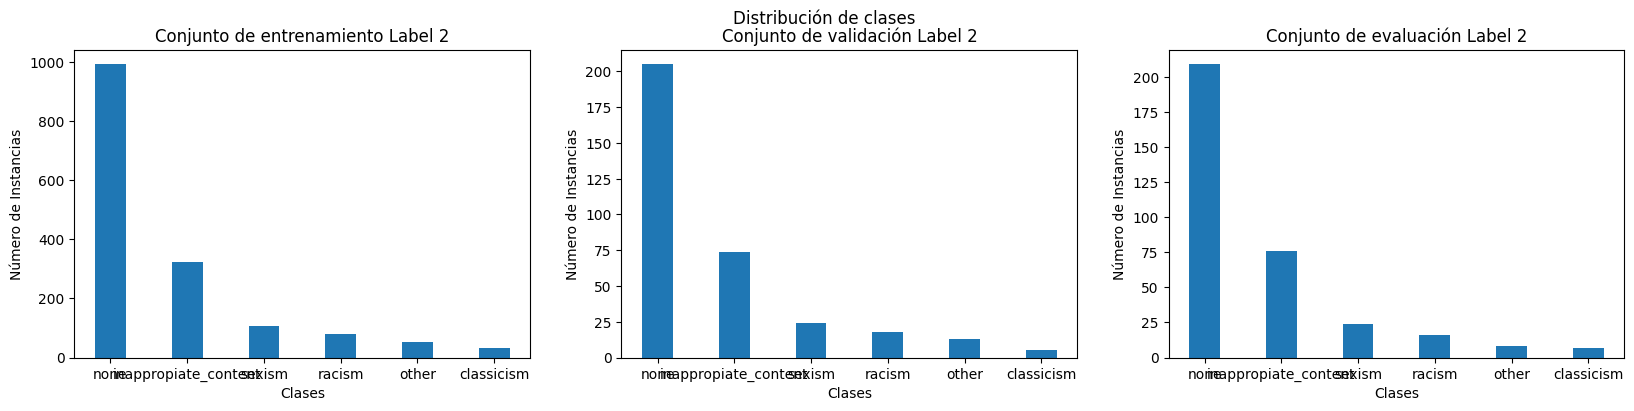

In [ ]:
import matplotlib.pyplot as plt

# Definir etiquetas
LABELS = list(counts_train2.keys())  # Usamos las etiquetas del segundo conjunto

fig, (ax_train, ax_val, ax_test) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Distribución de clases')

# Gráfico para conjunto de entrenamiento
ax_train.bar(LABELS, counts_train2.values(), width=0.4)
ax_train.set_title('Conjunto de entrenamiento Label 2')
ax_train.set_xlabel('Clases')
ax_train.set_ylabel('Número de Instancias')

# Gráfico para conjunto de validación
ax_val.bar(LABELS, counts_val2.values(), width=0.4)
ax_val.set_title('Conjunto de validación Label 2')
ax_val.set_xlabel('Clases')
ax_val.set_ylabel('Número de Instancias')

# Gráfico para conjunto de evaluación
ax_test.bar(LABELS, counts_test2.values(), width=0.4)
ax_test.set_title('Conjunto de evaluación Label 2')
ax_test.set_xlabel('Clases')
ax_test.set_ylabel('Número de Instancias')

plt.show()


#Data augmentation


In [ ]:
!pip install -q  transformers nlpaug

In [ ]:
import nlpaug.augmenter.word as naw

In [ ]:
df_train

,IMG,Text,Label_1,Label_2
780,DS_IMG_2389,UNLUAAR COM EDITFIQOS ENORTES Y POM GENIE PASE...,hate_speech,racism
331,DS_IMG_793,"""sacame una así como 1l que no me cuenta doy",none,none
194,DS_IMG_1014,"""Un chico que toca un instrumento no tocará ja...",inappropiate_content,inappropiate_content
2128,DS_IMG_48,11.40 A M. Como hiciste el chat negro? lo hice...,hate_speech,racism
2153,DS_IMG_2524,Lxs fans de Taylor Swift después de ver los pr...,none,none
...,...,...,...,...
1638,DS_IMG_728,"Torre de David, ruega por él Torre de marfil, ...",none,none
1095,DS_IMG_845,Está bien ser indigena Está bien ser asiatico ...,hate_speech,racism
1130,DS_IMG_2872,Tu tío LLegando al recalentado después de peLe...,inappropiate_content,inappropiate_content
1294,DS_IMG_396,-Yo: no creo que necesite carrito ni canasta ~...,none,none


In [ ]:
!pip install gensim

In [ ]:
# aug = naw.ContextualWordEmbsAug(model_path='dccuchile/bert-base-spanish-wwm-cased', action="substitute")

aug = naw.WordEmbsAug(
    model_type='word2vec', model_path='fasttext-sbwc.3.6.e20.vec',
    action="substitute")

augmented_texts = aug.augment(df_train.iloc[2]["Text"], n=3)

print("Texto original:")
print(df_train.iloc[2]["Text"])
print()
print("Textos generados:")
for new_text in augmented_texts:
    print(new_text)

# Baseline BETO

In [ ]:
tokenizer = BertTokenizer.from_pretrained('mariav/bert-base-spanish-wwm-cased-finetuned-tweets')
model = BertForSequenceClassification .from_pretrained(
    "mariav/bert-base-spanish-wwm-cased-finetuned-tweets",
    num_labels = 3,
    output_attentions = False,
    ignore_mismatched_sizes=True,
    output_hidden_states = False,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/730k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/721 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mariav/bert-base-spanish-wwm-cased-finetuned-tweets and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_text(texts, tokenizer, max_length):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Texto a codificar
                            add_special_tokens = True, # Agregar '[CLS]' y '[SEP]'
                            max_length = max_length,           # Longitud máxima de la secuencia de salida
                            padding = 'max_length',     # Relleno para asegurar la longitud de la secuencia
                            truncation=True,            # Truncar secuencias más largas que `max_length`
                            return_attention_mask = True,   # Generar las máscaras de atención
                            return_tensors = 'pt',     # Devolver tensores de tipo PyTorch
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convertir etiquetas de texto a números enteros
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(df_train['Label_1'])
val_labels_encoded = label_encoder.transform(df_val['Label_1'])
test_labels_encoded = label_encoder.transform(df_test['Label_1'])

In [ ]:
# Verificar los tipos de datos y valores únicos en las etiquetas
print("Tipo de datos de train_labels:", type(train_labels_encoded))
print("Tipo de datos de val_labels:", type(val_labels_encoded))
print("Tipo de datos de test_labels:", type(test_labels_encoded))

print("Valores únicos en train_labels:", np.unique(train_labels_encoded))
print("Valores únicos en val_labels:", np.unique(val_labels_encoded))
print("Valores únicos en test_labels:", np.unique(test_labels_encoded))

Tipo de datos de train_labels: <class 'numpy.ndarray'>
Tipo de datos de val_labels: <class 'numpy.ndarray'>
Tipo de datos de test_labels: <class 'numpy.ndarray'>
Valores únicos en train_labels: [0 1 2]
Valores únicos en val_labels: [0 1 2]
Valores únicos en test_labels: [0 1 2]


In [ ]:
MAX_LENGTH = 64

train_texts = df_train['Text'].values
train_labels = train_labels_encoded
val_texts = df_val['Text'].values
val_labels = val_labels_encoded
test_texts = df_test['Text'].values
test_labels = test_labels_encoded

train_input_ids, train_attention_masks = tokenize_text(train_texts, tokenizer, MAX_LENGTH)
val_input_ids, val_attention_masks = tokenize_text(val_texts, tokenizer, MAX_LENGTH)
test_input_ids, test_attention_masks = tokenize_text(test_texts, tokenizer, MAX_LENGTH)

# Crea los datasets de PyTorch
train_dataset = TensorDataset(train_input_ids, train_attention_masks, torch.tensor(train_labels))
val_dataset = TensorDataset(val_input_ids, val_attention_masks, torch.tensor(val_labels))
test_dataset = TensorDataset(test_input_ids, test_attention_masks, torch.tensor(test_labels))


In [ ]:
# Crea los dataloaders
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  # Dataset de entrenamiento
            sampler = RandomSampler(train_dataset), # Muestreo aleatorio para el entrenamiento
            batch_size = batch_size # Tamaño del lote
        )

validation_dataloader = DataLoader(
            val_dataset, # Dataset de validación
            sampler = SequentialSampler(val_dataset), # Secuencial para la validación
            batch_size = batch_size # Tamaño del lote
        )

test_dataloader = DataLoader(
            test_dataset, # Dataset de prueba
            sampler = SequentialSampler(test_dataset), # Secuencial para la prueba
            batch_size = batch_size # Tamaño del lote
        )

In [ ]:
# Envuelve el modelo en un objeto "device"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Parámetros de fine-tuning
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # Tasa de aprendizaje recomendada por BERT
                  eps = 1e-8 # Epsilon para evitar la división por cero
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Entrenamiento
epochs = 3

for epoch in range(epochs):
    # Entrenamiento
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_dataloader, desc="Entrenando"):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs[0]
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    # Cálculo de la pérdida promedio en el entrenamiento
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validación
    model.eval()
    total_val_loss = 0

    for batch in tqdm(validation_dataloader, desc="Validando"):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        loss = outputs[0]
        total_val_loss += loss.item()

    # Cálculo de la pérdida promedio en la validación
    avg_val_loss = total_val_loss / len(validation_dataloader)

    print(f'Epoch {epoch + 1}:')
    print(f'Entrenamiento Loss: {avg_train_loss}')
    print(f'Validación Loss: {avg_val_loss}')

Validando: 100%|██████████| 11/11 [01:04<00:00,  5.85s/it]


Epoch 1:
Entrenamiento Loss: 0.9043067884445191
Validación Loss: 0.8964630527929827


Validando: 100%|██████████| 11/11 [01:04<00:00,  5.86s/it]


Epoch 2:
Entrenamiento Loss: 0.7632646644115448
Validación Loss: 0.8832625800913031


Validando: 100%|██████████| 11/11 [01:04<00:00,  5.86s/it]

Epoch 3:
Entrenamiento Loss: 0.5603482645750045
Validación Loss: 0.9790103327144276


In [ ]:
ruta_guardado = '/content/drive/My Drive/PLN/nlp_models/BETO_TWITTER/'

In [ ]:
# Guardar el modelo fine-tuneado
model.save_pretrained(ruta_guardado)

In [ ]:
# Cargar el modelo
model = AutoModelForSequenceClassification.from_pretrained(ruta_guardado)

# Cargar el tokenizador
tokenizer = BertTokenizer.from_pretrained('mariav/bert-base-spanish-wwm-cased-finetuned-tweets')

In [ ]:
# Evaluación en el conjunto de prueba
model.eval()
total_test_loss = 0

for batch in tqdm(test_dataloader, desc="Evaluando"):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

    loss = outputs[0]
    total_test_loss += loss.item()

Evaluando: 100%|██████████| 11/11 [01:13<00:00,  6.68s/it]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    for batch in dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        _, predicted = torch.max(logits, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    return all_labels, all_preds

# Evaluar el modelo en el conjunto de prueba
test_labels, test_preds = evaluate_model(model, test_dataloader)

# Calcular métricas
accuracy = accuracy_score(test_labels, test_preds)
report = classification_report(test_labels, test_preds)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Accuracy: 0.5911764705882353
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.13      0.17        55
           1       0.49      0.24      0.32        76
           2       0.64      0.84      0.72       209

    accuracy                           0.59       340
   macro avg       0.46      0.40      0.41       340
weighted avg       0.54      0.59      0.54       340



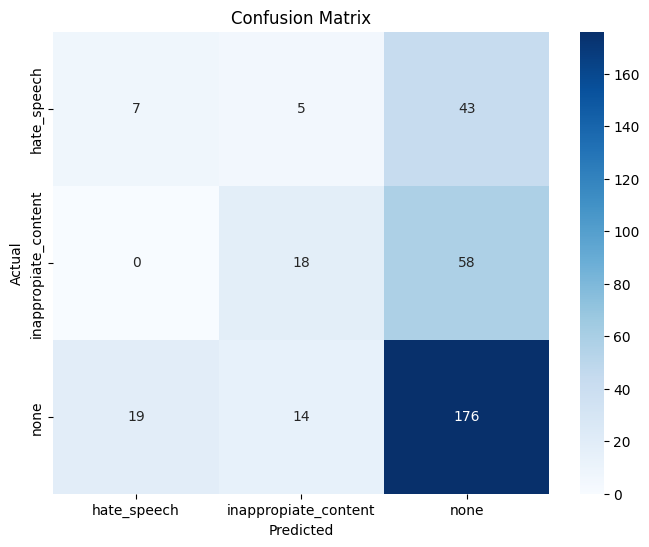

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(test_labels, test_preds)

# Mostrar la matriz de confusión utilizando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Cálculo de la pérdida promedio en el conjunto de prueba
avg_test_loss = total_test_loss / len(test_dataloader)
print(f'Pérdida en el conjunto de prueba: {avg_test_loss}')